In [57]:
import re 
import numpy as np
from matplotlib import pyplot as plt

np.random.seed(3)

test_text = '''where are you?
is she in mexico?
i am in greece.
she is in mexico.
is she in england?
'''

train_text = '''are you still here?
where are you?
he is in mexico.
are you tired?
i am tired.
are you in england?
were you in mexico?
is he in greece?
were you in england?
are you in mexico?
i am in mexico.
are you still in mexico? 
are you in greece again?
she is in england.
he is tired.
'''

def tokenise(s):
    return [i for i in re.sub('([.?])', ' \g<1>', s).strip().split(' ') if i]

def one_hot(y, classes):
    onehot = np.zeros((len(y), classes)) # creates matrix of ? rows, ? columns 
    
    # Iterate through y and update onehot's column to 1 based on the class
    # y [0, 1, 4, 3, 2]
    for i, v in enumerate(y):
        onehot[i][v] = 1
    return onehot

vocab = list(set([token for token in re.sub('([.?])', ' \g<1>', train_text)
             .replace(' ', '\n').strip().split('\n') if token]))
vocab += ['<BOS>', '<EOS>', '<PAD>']
vocab.sort()

word2idx = {word: idx for idx, word in enumerate(vocab)}
idx2word = {idx: word for word, idx in word2idx.items()}

print(word2idx)

pad = max([len(tokenise(i)) for i in train_text.split('\n')]) + 1
train_sentences = []
for line in train_text.strip().split('\n'):
        tokens = tokenise(line)
        padded = ['<BOS>'] + tokens + ['<EOS>'] + ['<PAD>'] * (pad - len(tokens))
        train_sentences.append([word2idx[token] for token in padded])

X = []
y = []

for sentence in train_sentences:
    for i in range(pad - 2):
            X.append([sentence[i], sentence[i+1]])
            y.append(sentence[i+2])
                  
X = np.array(X)
Y = np.array(y)
Yo = one_hot(Y, len(vocab))

print(X.shape)
print(Y.shape)
print(Yo.shape)
print('---')
w1 = np.random.randn(2, 6) 
w2 = np.random.randn(6, len(vocab)) 

print(w1.shape)
print(w2.shape)

bias = np.array(np.ones(6))
learning_rate = .001


{'.': 0, '<BOS>': 1, '<EOS>': 2, '<PAD>': 3, '?': 4, 'again': 5, 'am': 6, 'are': 7, 'england': 8, 'greece': 9, 'he': 10, 'here': 11, 'i': 12, 'in': 13, 'is': 14, 'mexico': 15, 'she': 16, 'still': 17, 'tired': 18, 'were': 19, 'where': 20, 'you': 21}
(75, 2)
(75,)
(75, 22)
---
(2, 6)
(6, 22)


In [58]:
test_sentences = []
for line in test_text.strip().split('\n'):
        tokens = tokenise(line)
        padded = ['<BOS>'] + tokens + ['<EOS>'] + ['<PAD>'] * (pad - len(tokens))
        test_sentences.append([word2idx[token] for token in padded])

X_test = []
y_test = []

for sentence in test_sentences:
    for i in range(pad - 2):
            X_test.append([sentence[i], sentence[i+1]])
            y_test.append(sentence[i+2])
                  
X_test = np.array(X_test)
Y_test = np.array(y_test)
# Yo = one_hot(Y, len(vocab))


In [59]:
def softmax(z):
    # Stabilizing softmax by z - np.max(z)
    # Calculating the exponential of z
    exps = np.exp(z - np.max(z))
    # Returning exp/ Sum(exp)
    return exps / np.sum(exps)

def cross_entropy(pred, true):
    # True labels X log of predicted labels
    losses = np.multiply(true, np.log(pred))
    # Calculating the mean of cross entropy
    # Multiplying by -ve to get a final +ve value (?)
    total_loss = -np.sum(losses)/true.shape[0]
    return losses, total_loss

def sigmoid(x):
    # Calculating 1 / 1 + exp(x)
    return 1/(1 + np.exp(-x))

def predict(X, w1, w2, bias): 
    # First layer ( X*W1 + B)
    pre1 = np.dot(X, w1) + bias
    # Activation function on First layer = Hidden Layer
    activation1 = sigmoid(pre1)
    # Second layer (Activation1 * w2)
    pre2 = np.dot(activation1, w2)
    # Activation function on second layer = (output layer)
    y_hat = softmax(pre2)
    
    # Returning output layer and hidden layer
    return y_hat, activation1

def generate(w1, w2, bias, prefix):
    # Converting our word input into numerical representation
    # ids = [word2idx[token] for token in prefix]
    # ids = []
    # for token in prefix:
        # ids.append(word2idx[token])
    # Creating array for input to the neural network model
    X = np.array(prefix)
    
    # Finding the output of the neural network
    y_hat, act1 = predict(X, w1, w2, bias)
    
    # Returning the word for the numerical output with the highest probability
    # return idx2word[np.argmax(y_hat)]
    return np.argmax(y_hat)

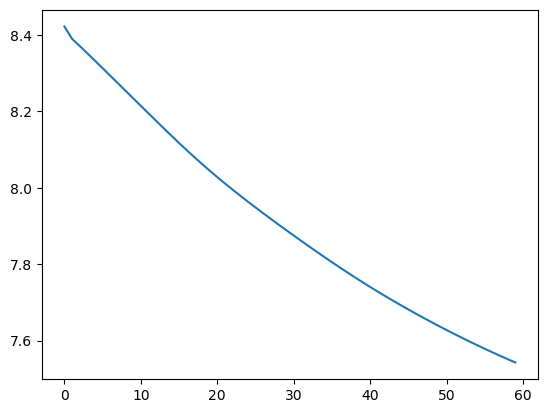

In [60]:
epochs = 60
all_losses = []

for i in range(epochs):
    # for every epoch, do the feed forward pass
    y_hat, activation1 = predict(X, w1, w2, bias)
    
    # Calculate loss after forward pass
    losses, total_loss = cross_entropy(y_hat, Yo)
    # Collecting the losses for every epoch in a list
    all_losses.append(total_loss)
    
    # Calculating gradients
    # Gradient of cross entropy loss w.r.t softmax activtion function = Y_hat - Yo
    diff = y_hat - Yo
    # Gradient of w2 = gradient of cross entroy * output of hidden layer (activation1)
    der_L_w2 = np.transpose(np.transpose(diff) @ activation1)
    # Gradient of sigmoid activation function
    der_sigmoid = activation1 * (1 - activation1)  # 75 X 6
    # Gradient of w1 = gradient of cross entropy * weights of output layer * gradeint of sigmoid * input layer
    der_L_w1 = np.transpose((diff @ w2.T) * der_sigmoid) @ X  
    # Gradient of bias1 = gradient of cross entropy * weights of output layer * gradeint of sigmoid
    der_bias = np.sum(np.transpose((diff @ w2.T) * der_sigmoid), axis = 1) # 6 X 75 , after sum its 6 
    
    # Updating w1, bias1, w2 by learning rate
    w1 -= learning_rate * der_L_w1.T
    w2 -= learning_rate * der_L_w2
    bias -= learning_rate * der_bias.T
    
# Plotting the losses    
plt.plot(all_losses)
    


In [61]:
next_word = generate(w1, w2, bias, ['i', 'am'])
print(next_word)

<class 'ValueError'>: data type must provide an itemsize

In [62]:
total = 0
correct = 0
for prefix, y in zip(X_test, Y_test):
    next_word = generate(w1, w2, bias, prefix)
    print(next_word, y)
    print([idx2word[token] for token in prefix], '->', idx2word[next_word])
    if next_word == y:
        correct += 1
    total += 1
    
print(correct,'/',total)

13 7
['<BOS>', 'where'] -> in
19 21
['where', 'are'] -> were
19 4
['are', 'you'] -> were
19 2
['you', '?'] -> were
19 3
['?', '<EOS>'] -> were
13 16
['<BOS>', 'is'] -> in
19 13
['is', 'she'] -> were
19 15
['she', 'in'] -> were
19 4
['in', 'mexico'] -> were
19 2
['mexico', '?'] -> were
19 6
['<BOS>', 'i'] -> were
19 13
['i', 'am'] -> were
19 9
['am', 'in'] -> were
19 0
['in', 'greece'] -> were
19 2
['greece', '.'] -> were
13 14
['<BOS>', 'she'] -> in
19 13
['she', 'is'] -> were
19 15
['is', 'in'] -> were
19 0
['in', 'mexico'] -> were
19 2
['mexico', '.'] -> were
13 16
['<BOS>', 'is'] -> in
19 13
['is', 'she'] -> were
19 8
['she', 'in'] -> were
19 4
['in', 'england'] -> were
19 2
['england', '?'] -> were
0 / 25
